In [218]:
import requests
import pandas as pb
import random
import collections
import string
import nltk
from nltk.util import ngrams
from scipy.sparse import csr_matrix
from collections import defaultdict
from sklearn.metrics import jaccard_score
import numpy as np
import matplotlib.pyplot as plt

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ardijan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Ardijan Rexhaj

# Assignment #2

# In This assignment you are asked to read a data which include 48505 articles (Documents). Then find the most similar documents using Locality Sensitive Hashing. Follow the lecture covering this topic step by step.

## 1. Data is available in Json format and you need to read it. 'https://www.ux.uis.no/~vsetty/data/assignment2_aricles.json' (5 points)


In [219]:
column_names = requests.get('https://www.ux.uis.no/~vsetty/data/assignment2_aricles.json').json()[0:1000]

df = pb.DataFrame.from_dict(column_names)

print(df)

     article_id                                              Title  \
0             0  Tikcro enters into research and license agreem...   
1             1  Facebook Friend Request Nearly Cost One North ...   
2             2  Amlin plc UK Regulatory Announcement: Total Vo...   
3             3                          Khaleda asks for security   
4             4  Liberian Health Clinics Reopen Slowly with Ren...   
..          ...                                                ...   
995         995  Rough seas continue, as fisherfolk seek Govt's...   
996         996  Presidential support escalates wind boom in Chile   
997         997   Dumb ways to die on Queensland roads this summer   
998         998  BBC delays airing of documentary on Charles an...   
999         999                                         Not Found!   

                                               Content  
0    Tikcro enters into research and license agreem...  
1    A North Carolina woman is trying to warn

## 2. Shingle the documents (10 points)
### Tips:
* Use string package to cleanup the articles e.g, str.maketrans('', '', string.
punctuation)
* It is better to convert text to lower case that way you get fewer n-grams
* apply ngrams(x.split(), n) using ngrams from nltk on the content + title for computing n-grams, for this data n = 2 is suffcient
  * You can use n-gram at word level for this task
  * try with different n-gram values 
  * You can use ngrams from nltk for this



In [250]:
def cleanup(s):
    t = str.maketrans('', '', string.punctuation+"“”‘’")
    return s.translate(t).lower()

def ngram_text(s):
    n = ngrams(nltk.word_tokenize(s), 2)
    c = collections.Counter(n)
    m=c.most_common(10_000)
    return [ w[0] for w in m]



df['Title'] =  df['Title'].apply(cleanup)
df['Content'] =  df['Content'].apply(cleanup)


text_df = pb.DataFrame({})
text_df["Article"] = df['Title']+" "+df['Content']

shingles_all_articles = pb.DataFrame({})
shingles_all_articles["Shingles"] = [text_df['Article'].str.cat(sep=' ')]

shingles_all_articles = shingles_all_articles["Shingles"].apply(ngram_text)[0]

shingles_each_article = pb.DataFrame({})
shingles_each_article["Shingles"] = text_df['Article'].apply(ngram_text)


#print(shingles_all_articles)
print(shingles_each_article)



                                              Shingles
0    [(research, and), (and, license), (license, ag...
1    [(friend, request), (a, friend), (when, she), ...
2    [(amlin, plc), (ordinary, shares), (voting, ri...
3    [(for, security), (the, hearing), (khaleda, as...
4    [(of, the), (renewed, vigilance), (in, liberia...
..                                                 ...
995  [(rough, seas), (trinidad, and), (and, tobago)...
996  [(in, the), (of, new), (of, the), (says, finat...
997  [(a, driver), (in, a), (driver, on), (an, hour...
998  [(phone, number), (your, account), (bbc, delay...
999  [(not, found), (found, error), (error, 404), (...

[1000 rows x 1 columns]



## 3. Convert n-grams into binary vector representation for each document. You can do some optimzations if the matrix is too big. (10 points)
* For example,

  * Select top 10000 most frequent n-grams.
  * You may also try smaller values of n (like 2 or 3) which result in fewer n-grams.
  * Finally, you can also try sparse matrix representation. Like csr_matrix from scipy.sparse. It works even with full vocabulary.
    * Given a list of n-grams for each document, see how to builid a sparse matrix here https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html



In [221]:

def to_binary_vec(article_shingles,all_shingles):
    column, row = [], []

    for c, article_ngrams in article_shingles['Shingles'].items():
        article_ngrams = set(article_ngrams)
        for r in range(len(all_shingles)):
            if all_shingles[r] in article_ngrams:
                column.append(c)
                row.append(r)


    return csr_matrix((len(row)*[1], (row, column)),shape=(len(all_shingles),len(article_shingles["Shingles"])))


binary_matrix = to_binary_vec(shingles_each_article,shingles_all_articles)

binary_matrix = pb.DataFrame(binary_matrix.todense())
binary_matrix



,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1,0,0,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,0,0,0
1,0,1,0,1,0,0,1,0,1,1,...,1,1,0,1,1,1,1,1,0,0
2,0,0,0,1,1,0,0,0,0,1,...,1,1,0,1,1,1,1,0,0,0
3,0,1,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,1,1,0,0
4,1,0,1,1,0,0,0,0,1,0,...,1,1,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4. We need hash function that maps integers 0, 1, . . . , k − 1 to bucket numbers 0 through k − 1. It might be impossible to avoid collisions but as long as the collions are too many it won't matter much. (10 points)
* The simplest would be using the builtin hash() function, it can be for example, hash(rownumber) % Numberofbuckets
* You can generate several of these hash functions by xoring a random integer (hash(rownumber)^randint) % Numberofbuckets
* It can also be a as simple as (rownumber * randint) % Numberofbuckets



In [222]:
random.seed(1337)


num_hash_funcs = 20
def make_hash_func():
    a = list(range(1,10_001))
    random.shuffle(a)
    return a

hash_funcs = []
for _ in range(num_hash_funcs):
    hash_funcs.append(make_hash_func())

# pb.DataFrame(hash_funcs)





In [223]:
def calc_signature(row):
    signature = []
    for func in hash_funcs:
        for i in range(1,10_001):
            if row[func.index(i)] == 1:
                signature.append(i)
                break
    return signature

signed_matrixes = binary_matrix.apply(calc_signature,axis=0)
signed_matrixes



,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,367,5,94,82,44,573,110,120,56,26,...,33,45,464,134,152,138,7,196,2493,62
1,398,44,723,6,71,2500,107,149,355,339,...,20,345,752,2,656,45,14,16,483,2337
2,76,40,275,40,21,1328,40,76,40,76,...,40,76,76,20,76,20,41,215,1467,2040
3,273,117,93,56,44,2091,130,624,117,103,...,27,21,306,65,143,18,28,4,196,80
4,328,133,189,229,34,1120,137,149,69,96,...,22,165,469,71,178,198,22,109,452,469
5,117,55,164,124,280,561,1,730,15,7,...,3,75,1037,40,13,1,81,7,2537,1037
6,729,15,292,34,34,773,74,458,1,106,...,34,34,255,228,406,16,66,214,43,434
7,88,9,4,141,12,1678,9,96,139,7,...,5,84,1485,16,325,122,4,118,858,1121
8,378,6,565,237,93,75,131,35,164,2,...,12,80,1020,3,433,66,73,263,382,816
9,392,33,349,33,33,646,53,310,31,29,...,25,65,580,33,33,33,11,11,262,427


## 5. Compute minhash following the faster algorithm from the lecture (10 points)


## 6. Hash signature bands into buckets. Find a way to combine all the  signature values in a band and hash them into a number of buckets ususally very high. (10 points)
* Easiest way is to add all the signature values in the bucket and use a similar hash function like before
* You should use the same hash function for all bands. And all documents ending up in same bucket for at least one band are considered as candidate pairs.



In [244]:

num_bands = 6
num_buckets = 1000
def split_vec_and_hash(row):
    row = list(row)
    size = len(row)//num_bands
    return [hash(tuple(row[i*size:(i+1)*size]))%num_buckets for i in range(num_bands)]


split_signatures = signed_matrixes.apply(split_vec_and_hash,axis=0)

## 7. Tune parameters to make sure the threshold is appropriate. (10 points)
* plot the probability of two similar items falling in same bucket for different threshold values



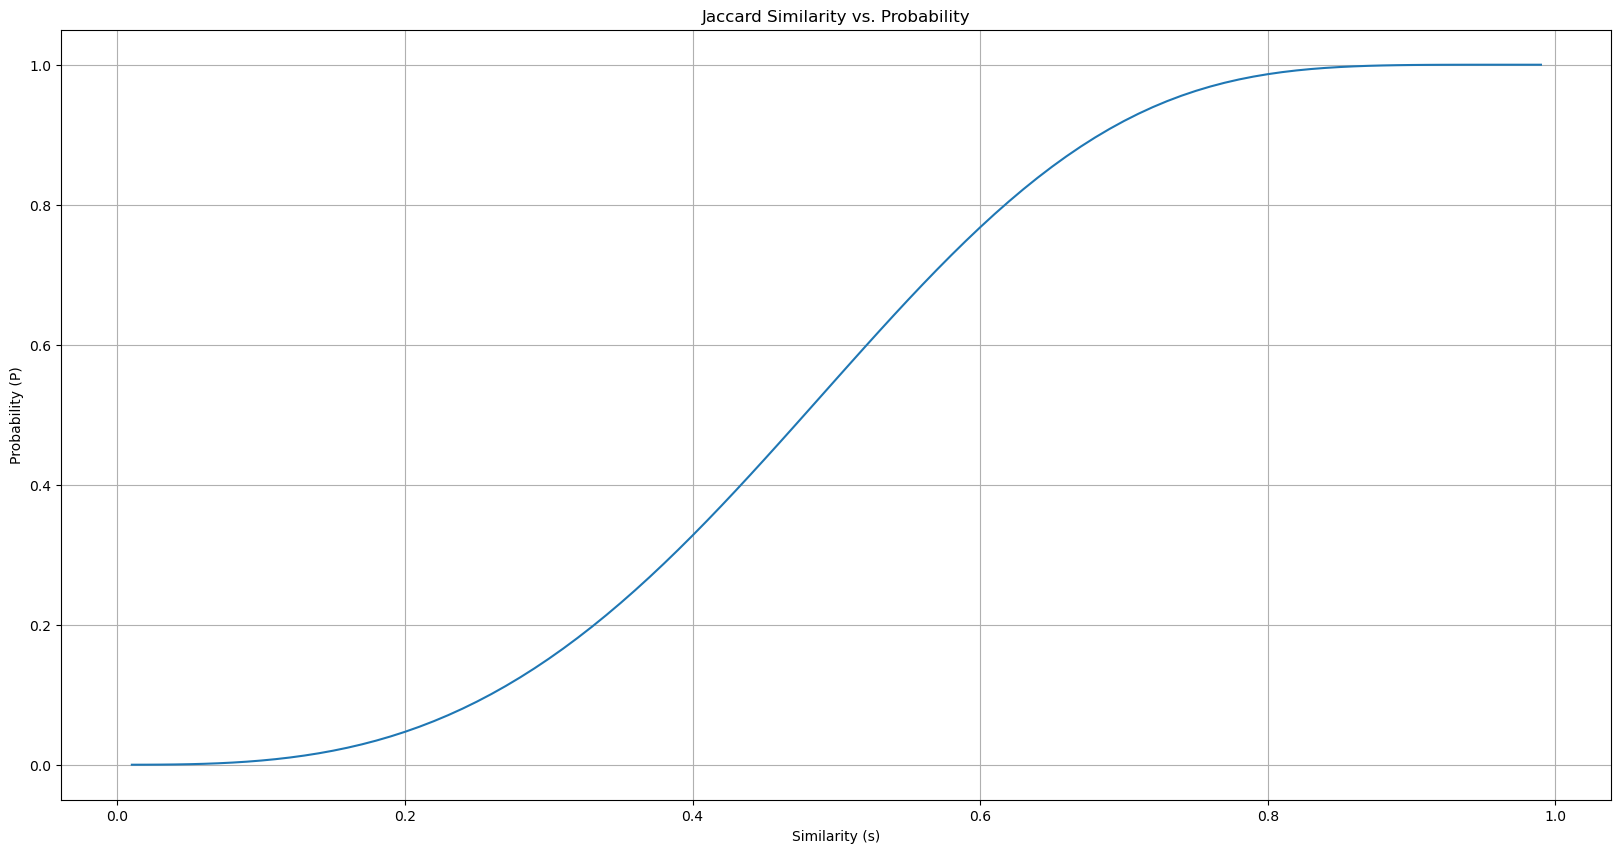

In [245]:


s_values = []
P_values = []

for s in np.arange(0.01, 1, 0.01):
    size = signed_matrixes.shape[0]
    r = size // num_bands
    p = 1 - (1 - s**r)**num_bands
    s_values.append(s)
    P_values.append(p)

plt.figure(figsize=(20, 10))
plt.plot(s_values, P_values)
plt.xlabel('Similarity (s)')
plt.ylabel('Probability (P)')
plt.title('Jaccard Similarity vs. Probability')
plt.grid(True)
plt.show()


## 8. Choose the best parameters and get nearest neighbors of each articles (20 points)
* Jaccard Similarity
* convert hash table into dictionary of article ids and its other articles that hashed in at least 1 same bucket



In [246]:
nearest_neighbours = []
for _ in range(split_signatures.shape[1]):
    nearest_neighbours.append([])

def find_nearest_neighbours(row):
    buckets = {}
    for i in range(len(row)):
        v = row[i]
        if v not in buckets:
            buckets[v] = set()

        # for each of the elements already in the bucket, add yourself to their nearest neighbors list
        for doc in buckets[v]:
            if i not in nearest_neighbours[doc] and doc!=i:
                nearest_neighbours[doc].append(i)

        # and add them to yours
        buckets[v].add(i)
        for doc in buckets[v]:
            if doc not in nearest_neighbours[i] and doc!=i:
                nearest_neighbours[i].append(doc)

split_signatures.apply(find_nearest_neighbours,axis=1)

neighbors_df = pb.DataFrame({})
neighbors_df["Neighbors"] = nearest_neighbours

neighbors_df

,Neighbors
0,"[596, 864, 330, 937, 691]"
1,"[722, 328, 642, 689, 878]"
2,[869]
3,"[212, 375, 153, 653, 746, 290, 592]"
4,"[285, 952]"
...,...
995,[727]
996,"[169, 466, 78, 905, 419]"
997,"[691, 699, 984, 454, 332, 559, 395, 268, 327]"
998,"[17, 730, 899, 98, 504, 308, 412, 293]"


## 9. Write the nearest neibhors of each document to submissions.csv (comma separated, first column is the current document followed by a list of nearest neighbors) file and get the score (10 points)


In [249]:
def calculate_jaccard_similarity(a, b):
    intersection = len(a.intersection(b))
    union = len(a.union(b))
    return intersection / union


column_names = {
'document': [],
'neighbour': [],
'score': []
}

similarity_score_above_threshold = pb.DataFrame(column_names)

similarity_score_above_threshold=similarity_score_above_threshold.astype({'document': 'int32', 'neighbour': 'int32'})


threshold = 0.3

for a in range(len(nearest_neighbours)):

    for b in nearest_neighbours[a]:

        similarity_value = calculate_jaccard_similarity(set(shingles_each_article["Shingles"][a]),set(shingles_each_article["Shingles"][b]))

        if similarity_value > threshold:
            new_row = pb.DataFrame({'document': [int(a)], 'neighbour': [int(b)], 'score': [similarity_value]})
            similarity_score_above_threshold = pb.concat([similarity_score_above_threshold, new_row], ignore_index=True)


similarity_score_above_threshold.to_csv('submission.csv', index=False)

similarity_score_above_threshold



,document,neighbour,score
0,9,825,0.789474
1,12,269,0.566038
2,12,475,0.576923
3,16,133,1.000000
4,27,672,0.968123
...,...,...,...
973,978,130,0.548387
974,978,681,0.515152
975,978,213,0.708333
976,978,438,0.548387


## 10. Write a report + notebook + submission file in a zip file (5 points)
